Welcome to this data science project!
Here we're going to take a look at Rossmann store sales to analyze the different circumstances of each store.
Rossmann is a pretty big drugstore chain with stores in eight countries.
The goal is to analyze and optimize sales, thus helping in the decision-making of the management.
In the end we will have a reasonably accurate prediction the eight weeks after the our dataset ends.

First and foremost we need to establish where the data comes from and what the variables actually mean. For that I have prepared a notebook called 'Circumstancial Data.ipynb'. Please take a look at it if you wish to see the page the data is coming from or to have a better understanding of the variables.

In [1]:
# Import basic packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
# Read the data 'store.csv' and 'train.csv'

store_data = pd.read_csv('store.csv')
train_data = pd.read_csv('train.csv', low_memory = False)

# First Look at the Data

Let us look at some basic things about the datasets like number of entries, what the columns look like and the amount of missing data:

In [3]:
# Size of store_data

len(store_data)

1115

In [4]:
# Size of train_data

len(train_data)

1017209

In [5]:
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [7]:
train_data['Date'].info()

# This is to check which format 'Date' is in

<class 'pandas.core.series.Series'>
RangeIndex: 1017209 entries, 0 to 1017208
Series name: Date
Non-Null Count    Dtype 
--------------    ----- 
1017209 non-null  object
dtypes: object(1)
memory usage: 7.8+ MB


In [8]:
# Since 'Date' has been an object and not in datetime format let us fix this

train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data['Date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1017209 entries, 0 to 1017208
Series name: Date
Non-Null Count    Dtype         
--------------    -----         
1017209 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 7.8 MB


In [9]:
# Checking for missing values in store_data

store_data.isna().any()

Store                        False
StoreType                    False
Assortment                   False
CompetitionDistance           True
CompetitionOpenSinceMonth     True
CompetitionOpenSinceYear      True
Promo2                       False
Promo2SinceWeek               True
Promo2SinceYear               True
PromoInterval                 True
dtype: bool

In [10]:
store_data[store_data['CompetitionDistance'].isna()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [11]:
len(store_data[store_data['CompetitionOpenSinceMonth'].isna()])

354

In [12]:
len(store_data[store_data['PromoInterval'].isna()])

# Promo2SinceWeek and Promo2SinceYear have the same amount of missing values, presumably it's the same rows

544

In [13]:
# Looking at the store types and assortment combinations

store_data[['StoreType', 'Assortment']].value_counts()

StoreType  Assortment
a          a             381
           c             221
d          c             220
           a             128
c          a              77
           c              71
b          b               9
           a               7
           c               1
Name: count, dtype: int64

In [14]:
# Which days of the week are the stores open?

train_data['DayOfWeek'].value_counts()

DayOfWeek
5    145845
4    145845
3    145665
2    145664
1    144730
7    144730
6    144730
Name: count, dtype: int64

In [15]:
# Checking for missing values in train_data

train_data.isna().any()

Store            False
DayOfWeek        False
Date             False
Sales            False
Customers        False
Open             False
Promo            False
StateHoliday     False
SchoolHoliday    False
dtype: bool

In [16]:
# Checking if the amount of different stores in train_data is the same as in store_data

len(train_data['Store'].value_counts())

1115

Our first look at the data shows that there are 1115 stores with overall 1017209 points of data. There are no missing values in 'train_data' and the missing values in 'store_data' either indicate missing knowledge of competitors - which is perfectly natural - or the absence of ongoing promotions ('Promo2' and the related ones). Overall there is very little data missing in this dataset. Furthermore we can see that most stores are of the types 'a' and 'd', with a few types 'c' and very little 'b'. Last but not least the stores are open very regularly - pretty much every day of the week to an equal degree.

# Data Engineering and Exploratory Data Analaysis

Before we continue let us take care of these missing values to interpret them better. First let us look at the 3 stores that are missing the distance from the competitors. We can't really tell if these values are missing because of lack of information or because of such a high distance that it's a relevant variable anymore. In any case we shouldn't go very wrong by replacing it with the mean value:

In [17]:
# Importing the package for imputing

from sklearn.impute import SimpleImputer

In [18]:
# Creating an instance of the imputer

SI = SimpleImputer(strategy = 'mean')

In [19]:
SI.fit(np.array(store_data['CompetitionDistance']).reshape(-1, 1))

SimpleImputer()

In [20]:
# Replacing the values in store_data

store_data['CompetitionDistance'] = SI.transform(np.array(store_data['CompetitionDistance']).reshape(-1, 1))

In [21]:
# Checking for missing values again

store_data['CompetitionDistance'].isna().any()

False

This will do it for the data on competition. The amount of missing values for the other variables is too high to impute with the mean and it would skew the data too much if we used an arbitrary value. Next we will replace the missing values in 'PromoInterval' with the string 'None'. This will be easier to work with if necessary.

In [22]:
# Using .fillna() to replace the missing values

store_data['PromoInterval'] = store_data['PromoInterval'].fillna('None')

In [23]:
store_data['PromoInterval'].value_counts()

PromoInterval
None                544
Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: count, dtype: int64

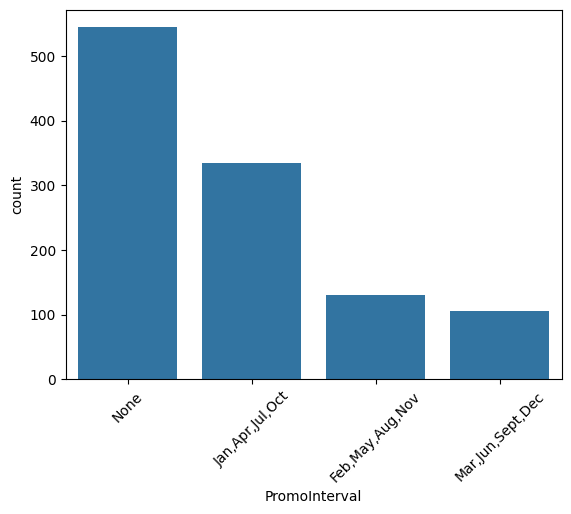

In [24]:
sns.barplot(store_data['PromoInterval'].value_counts())
plt.xticks(rotation = 45) ;

This is a barplot of the data analyzed above regarding ongoing promotions.

We will leave the imputation at that. On a side note we can see that about half of the stores have ongoing promotions while the other half doesn't.

For now let us look at the correlation between customers and sales:

In [25]:
train_data[['Customers', 'Sales']].mean()

Customers     633.145946
Sales        5773.818972
dtype: float64

<Axes: xlabel='Customers', ylabel='Sales'>

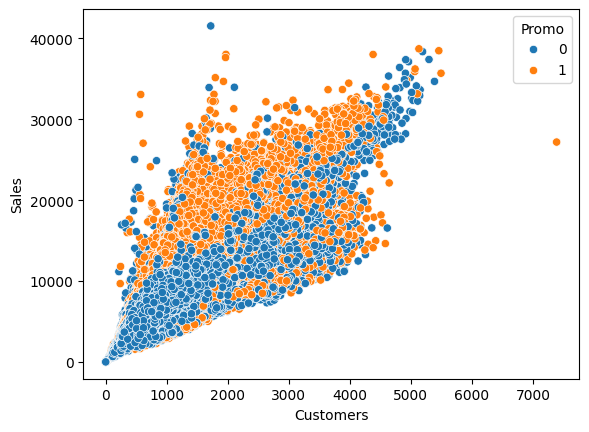

In [26]:
sns.scatterplot(data = train_data, x = 'Customers', y = 'Sales', hue = 'Promo')

We can see that there is an obviously positive correlation between customers and sales. To be more detailed the average customer buys around 8-10 products per visit. Furthermore there is a bit of a spread with the low end being at around 2.5 sales per customer (say 10000 sales at 4000 customers) and the vague high end being at around 15-20 sales per customer (say 30000 sales at 1500 customers). There are some higher ratios but they are split off from the biggest cluster. Also regarding promotions: We can see that on average they lead to more sales per customer but there are also a fair amount cases of more customers but less sales per customer.

In [27]:
# Temporarily merging data for a comparison

merged_data = pd.merge(train_data, store_data, on = 'Store', how = 'left')
merged_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,None
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,None
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,None


<Axes: xlabel='Customers', ylabel='Sales'>

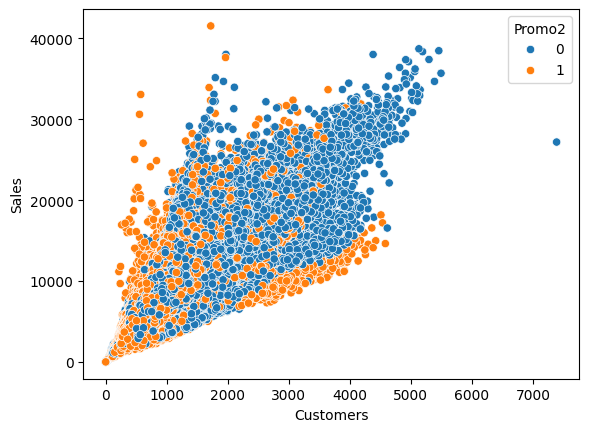

In [28]:
sns.scatterplot(data = merged_data, x = 'Customers', y = 'Sales', hue = 'Promo2')

This graph is using the ongoing 'Promo2' contrary to the regular 'Promo' as colored value. We can see that 'Promo2' has a bit more variance compared to 'Promo'.

To analyze how the days can affect the customers and sales we can look at the following:

In [29]:
# Average custommers pper weekday
# Only look at the open stores here

train_data[train_data['Open'] == 1].groupby('DayOfWeek')['Customers'].mean()

DayOfWeek
1     855.444984
2     769.986753
3     740.598876
4     755.569784
5     781.771639
6     660.177526
7    1441.532424
Name: Customers, dtype: float64

In [30]:
train_data[train_data['Open'] == 1].groupby('DayOfWeek')['Sales'].mean()

DayOfWeek
1    8216.073074
2    7088.113656
3    6728.122978
4    6767.310159
5    7072.677012
6    5874.840238
7    8224.723908
Name: Sales, dtype: float64

<Axes: xlabel='DayOfWeek', ylabel='Customers'>

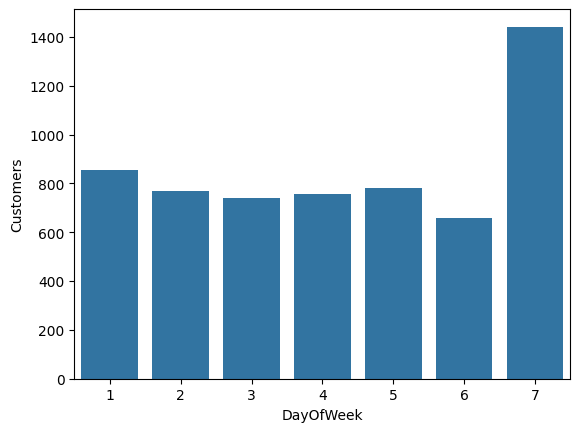

In [31]:
# Visualization of customers per weekday

sns.barplot(train_data[train_data['Open'] == 1].groupby('DayOfWeek')['Customers'].mean())

<Axes: xlabel='DayOfWeek', ylabel='Sales'>

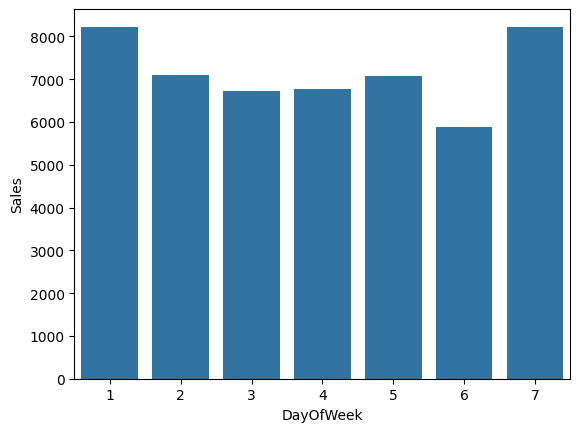

In [32]:
# Visualization of sales per weekday

sns.barplot(train_data[train_data['Open'] == 1].groupby('DayOfWeek')['Sales'].mean())

In [33]:
merged_data[merged_data['StoreType'] == 'b']['DayOfWeek'].value_counts()

DayOfWeek
5    2269
4    2269
3    2268
2    2268
1    2252
7    2252
6    2252
Name: count, dtype: int64

We can see that, on average, you have a lot more customers on Sundays than on other days. However the sales are not that much greater than Monday sales so opening on Sundays can still be a questionable decision given that it's usually a rest day. On a related note, store type 'b' seems to be open on every day so opening on Sundays seems to be standard practice for these stores.

Given that the goal is to predict sales on a weekly basis let us make sure to convert the data into weekly numbers. Additionally since we want each individual store to check up on their performance we are grouping it by store:

In [34]:
# Set 'Date' as index
train_data.set_index('Date', inplace=True)

In [35]:
# Define custom aggregation function for our non-numeric column
# We're noting down if a holiday occured during the week, leaving out the information if a type of holiday occured multiple times during a week

def aggregate_strings(series):
    return ', '.join(series.unique())

# Group by 'Store' and resample by week
# We're calling it train_data_w with w for weekly

train_data_w = train_data.groupby('Store').resample('W').agg({
    'Sales': 'sum',
    'Customers': 'sum',
    'Open': 'sum',
    'Promo': 'sum',
    'StateHoliday': aggregate_strings,
    'SchoolHoliday': 'sum'
}).reset_index()

# DayOfWeek has been left out since you don't need the information of what days are included in a week

In [36]:
# Check what's in 'StateHoliday'

np.unique(train_data_w['StateHoliday'])

array(['', '0', '0, a', '0, b', '0, c', 'a, 0', 'b, 0'], dtype=object)

In [37]:
train_data_w[train_data_w['StateHoliday'] == '']['Open'].value_counts()

Open
0    4500
Name: count, dtype: int64

In [38]:
# Bring together the different permutations of strings
# Since all the entries with '' state holidays are not open it should be fine for those entries to be '0'

train_data_mapping = {
    '0, a': 'a, 0',
    '0, b': 'b, 0',
    '0, c': 'c, 0',
    '': '0'
}
f = lambda x: train_data_mapping.get(x, x)
train_data_w['StateHoliday'] = train_data_w['StateHoliday'].map(f)

In [39]:
train_data_w['StateHoliday'].value_counts()

StateHoliday
0       121834
a, 0     19951
b, 0      6690
c, 0      2050
Name: count, dtype: int64

Now we're going to merge the train data and the store data. Just merging it like above leads to 'Promo2' applying '1' to a store that might not yet have implemented an ongoing promotion. So in the following lines of code we're going to make sure that 'Promo2' is displayed correctly for the right timeframes.

In [40]:
# Convert Promo2SinceYear and Promo2SinceWeek to integers where possible
# This is to ensure that the 'Promo2SinceYear' and 'Promo2SinceWeek' values will be displayed correctly and comparable to the 'Date' format values

store_data['Promo2SinceYear'] = store_data['Promo2SinceYear'].apply(lambda x: int(x) if not pd.isna(x) else x)
store_data['Promo2SinceWeek'] = store_data['Promo2SinceWeek'].apply(lambda x: int(x) if not pd.isna(x) else x)

# Merge the DataFrames on the 'Store' column

df = pd.merge(train_data_w, store_data, on='Store', how='left')

promo2_list = []

# Iterate over the rows of the merged DataFrame
# Check for NaN values in Promo2SinceYear and Promo2SinceWeek

for i, row in df.iterrows():
    if pd.notna(row['Promo2SinceYear']) and pd.notna(row['Promo2SinceWeek']):
        promo2_start_date = pd.to_datetime(f"{int(row['Promo2SinceYear'])}-{int(row['Promo2SinceWeek'])}-1", format="%Y-%W-%w", errors='coerce')
        if pd.notna(promo2_start_date) and row['Date'] >= promo2_start_date:
            promo2_list.append(1)
        else:
            promo2_list.append(0)
    else:
        promo2_list.append(0)

In [41]:
# Check if the list at least has the right values and length

print(np.unique(promo2_list))
print(len(promo2_list))

[0 1]
150525


In [42]:
# Replace the original 'Promo2' with the corresponding list

df['Promo2'] = promo2_list

Let us compare the different numbers of ongoing promotion with and without altering the 'Promo2' values:

In [43]:
merged_data_unmodified = pd.merge(train_data_w, store_data, on='Store', how='left')
merged_data_unmodified['Promo2'].value_counts()

Promo2
1    77085
0    73440
Name: count, dtype: int64

In [44]:
df['Promo2'].value_counts()

Promo2
0    84334
1    66191
Name: count, dtype: int64

We can see a difference of about 11000 pieces of data showing 'Promo2' at the wrong dates which is a pretty significant difference in the weekly dataset of around 150000.

To better analyze the performance of each store we will add some variables to the DataFrame:

In [45]:
# Average sales per day

df['AvgSalesPerDay'] = df['Sales'] / df['Open']

In [46]:
# Remove the NaN values for 'Open' == 0
# We will be replacing them with 0 since there is nothing sold

df['AvgSalesPerDay'] = df['AvgSalesPerDay'].fillna(0)
df['AvgSalesPerDay'].isna().any()

False

In [47]:
# Customers per day

df['CustomersPerDay'] = df['Customers'] / df['Open']

In [48]:
# # Remove the NaN values for 'Open' == 0
# We will be replacing them with 0 since there are no customers

df['CustomersPerDay'] = df['CustomersPerDay'].fillna(0)
df['CustomersPerDay'].isna().any()

False

In [49]:
# Sales per customer

df['SalesPerCustomer'] = df['Sales'] / df['Customers']

In [50]:
# # Remove the NaN values for 'Open' == 0
# We will be replacing them with 0  since there are no sales or customers

df['SalesPerCustomer'] = df['SalesPerCustomer'].fillna(0)
df['SalesPerCustomer'].isna().any()

False

Last but not least to finalize our DataFrame we're going to get rid of the variable 'Promo2SinceWeek' since the week a promotion started could do more harm than good within the context of analyzing the sales themselves. The same will go for 'CompetitionSinceMonth'. However we're going to keep 'Promo2SinceYear' since the duration of an ongoing promotion might be a more relevant factor.

In [51]:
# Remove 'Promo2SinceWeek'

df.drop(['Promo2SinceWeek', 'CompetitionOpenSinceMonth'], axis = 1, inplace = True)

In [52]:
df.head()

,Store,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,PromoInterval,AvgSalesPerDay,CustomersPerDay,SalesPerCustomer
0,1,2013-01-06,19340,2500,4,0,"a, 0",6,c,a,1270.0,2008.0,0,NaN,None,4835.000000,625.000000,7.736000
1,1,2013-01-13,32952,3918,6,5,0,5,c,a,1270.0,2008.0,0,NaN,None,5492.000000,653.000000,8.410413
2,1,2013-01-20,25978,3417,6,0,0,0,c,a,1270.0,2008.0,0,NaN,None,4329.666667,569.500000,7.602575
3,1,2013-01-27,33071,3862,6,5,0,0,c,a,1270.0,2008.0,0,NaN,None,5511.833333,643.666667,8.563180
4,1,2013-02-03,28693,3561,6,0,0,0,c,a,1270.0,2008.0,0,NaN,None,4782.166667,593.500000,8.057568


Now we can look at some graphs again - we are interested to see how the various variables affect the stores' performance.

<Axes: xlabel='StoreType', ylabel='AvgSalesPerDay'>

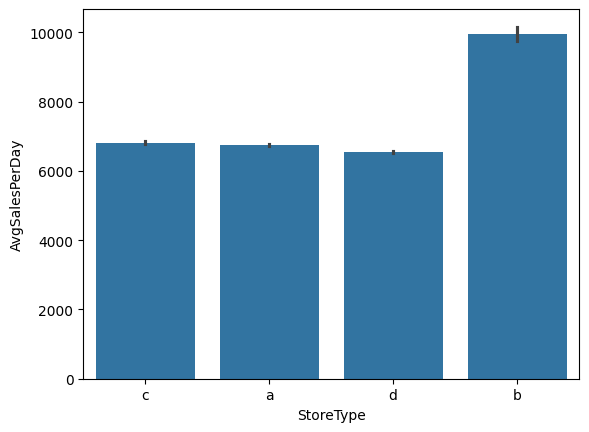

In [53]:
# Sales per day by store type

sns.barplot(data = df, x = 'StoreType', y = 'AvgSalesPerDay')

<Axes: xlabel='StoreType', ylabel='CustomersPerDay'>

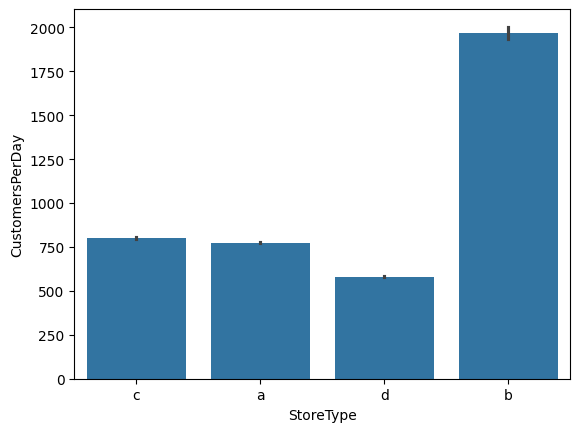

In [54]:
# Customers per day by store type

sns.barplot(data = df, x = 'StoreType', y = 'CustomersPerDay')

<Axes: xlabel='Assortment', ylabel='SalesPerCustomer'>

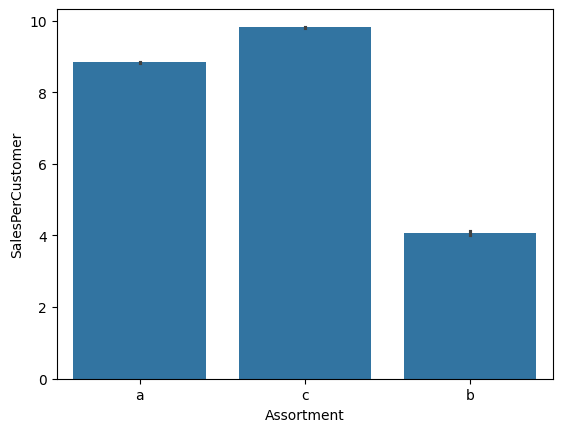

In [55]:
# Sales per customer by assortment

sns.barplot(data = df, x = 'Assortment', y = 'SalesPerCustomer')

Note that store assortment 'b' is only associated to store type 'b'. While we have high average sales per day in store type 'b' as well as high customer count per day with store type 'b' we have low sales per customer in assortment 'b' which only exists in the corresponding store type. This means that in store type/assortment 'b' we have a lot of customers and overall a lot of sales, but less sales per customer. A reasonable follow-up explanation here is that the low sample size in both store type and assortment leads to potentially extreme results.

<Axes: xlabel='Customers', ylabel='Sales'>

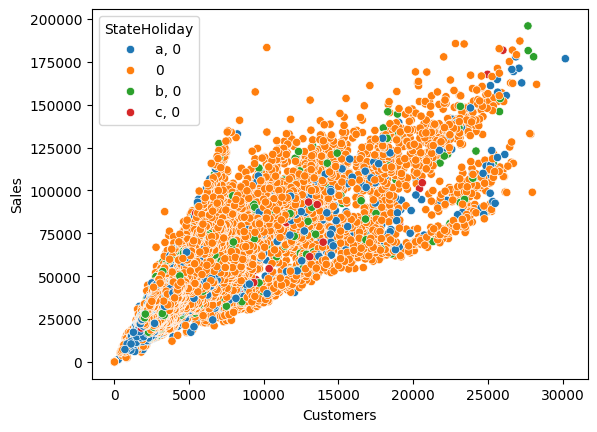

In [56]:
# Sales and customers with state holidays

sns.scatterplot(data = df, x = 'Customers', y = 'Sales', hue = 'StateHoliday')

There doesn't seem to be a too great correlation of sales and state holidays. However some of the weeks with the highest and lowest numbers of sales and customers have been on weeks with public and Easter holidays.

<Axes: xlabel='SchoolHoliday', ylabel='CustomersPerDay'>

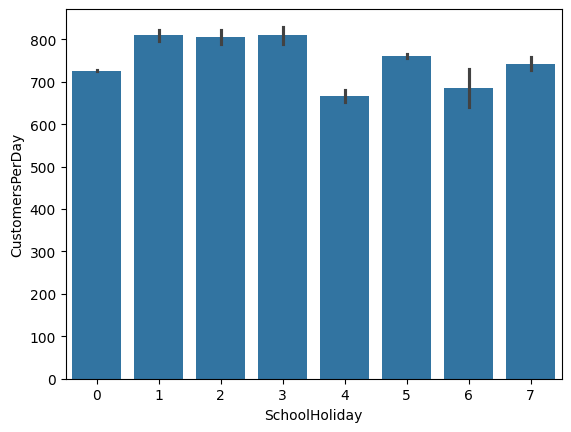

In [57]:
# Average Customers per day per number of school holidays

sns.barplot(data = df, x = 'SchoolHoliday', y = 'CustomersPerDay')

It does look like there is a slight increase in average customers per day if there are one to three days of school holidays.

<Axes: xlabel='CompetitionDistance', ylabel='Sales'>

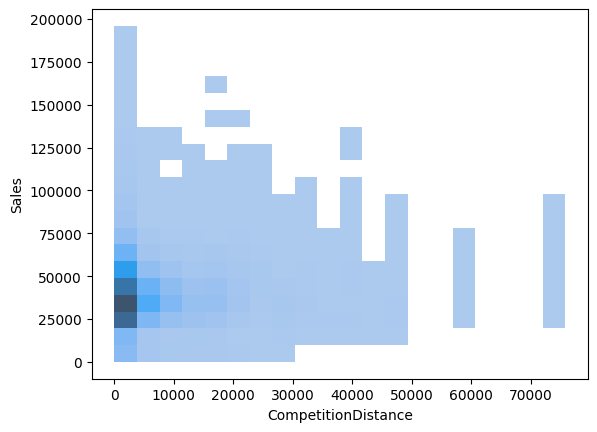

In [58]:
# Sales by competition distance

sns.histplot(data = df, x = 'CompetitionDistance', y = 'Sales', bins = 20)

In [59]:
len(df[df['CompetitionDistance'] <= 10000])

125280

In [60]:
# Average competition distance

df['CompetitionDistance'].mean()

5404.901079136691

What we can see here is that the highest sales occured in store with low distance to competition. It could be because the stores are located in positions with higher demand. Also sales do not seem to go up with higher competition distance except starting at 45-50 km and not too many samples. Only 25000 points of data go past 10 km competition distance.

To see what actually is influencing the sales we're going to check the correlation matrix.

In [61]:
correlation_matrix = df.select_dtypes(include = np.number).corr()

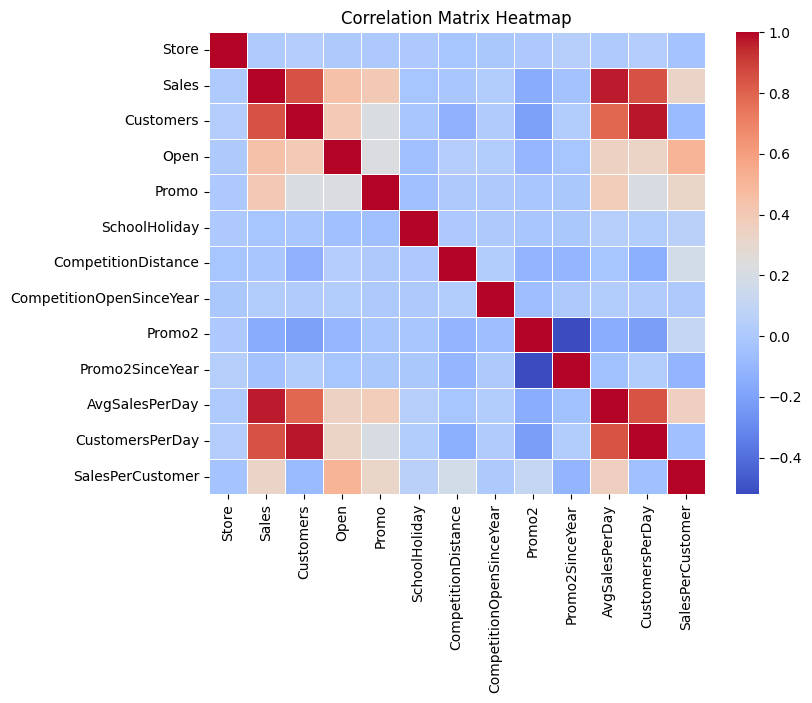

In [62]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot = False, cmap = 'coolwarm', linewidths = 0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

It looks like 'Customers', 'Open' and 'Promo' have a quite positive correlation with 'Sales' while 'Promo2' seems to have a slightly negative one, presumably caused by stores that haven't been doing too well in the first place. Note that 'AvgSalesPerDay', 'CustomersPerDay' and 'SalesPerCustomer' are direct derivative variables of either 'Sales' or 'Customers' so they shouldn't be considered too closely.

Let us actually look at the weeks with the highest sales as well as highest average sales per day:

In [63]:
# Highest Sales
# Top 10

df.sort_values(by = ['Sales'], ascending = False).head(10)

,Store,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,PromoInterval,AvgSalesPerDay,CustomersPerDay,SalesPerCustomer
35352,262,2015-04-05,195930,27682,7,5,"b, 0",0,b,a,1180.0,2013.0,0,NaN,None,27990.000000,3954.571429,7.077885
35285,262,2013-12-22,187129,27144,7,5,0,2,b,a,1180.0,2013.0,0,NaN,None,26732.714286,3877.714286,6.893936
33800,251,2013-12-22,185646,22832,6,5,0,0,a,c,340.0,NaN,0,NaN,None,30941.000000,3805.333333,8.130957
110210,817,2013-12-22,185407,23411,6,5,0,0,a,a,140.0,2006.0,0,NaN,None,30901.166667,3901.833333,7.919653
113585,842,2013-12-22,183327,10200,6,5,0,0,d,c,1200.0,2007.0,0,NaN,None,30554.500000,1700.000000,17.973235
150305,1114,2013-12-22,182653,25758,6,5,0,2,a,c,870.0,NaN,0,NaN,None,30442.166667,4293.000000,7.091117
35337,262,2014-12-21,181821,26644,7,5,0,0,b,a,1180.0,2013.0,0,NaN,None,25974.428571,3806.285714,6.824088
35338,262,2014-12-28,181768,26005,7,0,"c, 0",5,b,a,1180.0,2013.0,0,NaN,None,25966.857143,3715.000000,6.989733
35247,262,2013-03-31,181526,27700,7,5,"b, 0",0,b,a,1180.0,2013.0,0,NaN,None,25932.285714,3957.142857,6.553285
75785,562,2013-12-22,179122,26916,7,5,0,0,b,c,1210.0,NaN,0,NaN,None,25588.857143,3845.142857,6.654852


In [64]:
# Highest average sales per day
# Top 10

df.sort_values(by = ['AvgSalesPerDay'], ascending = False).head(10)

,Store,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,PromoInterval,AvgSalesPerDay,CustomersPerDay,SalesPerCustomer
33800,251,2013-12-22,185646,22832,6,5,0,0,a,c,340.0,NaN,0,NaN,None,30941.000000,3805.333333,8.130957
110210,817,2013-12-22,185407,23411,6,5,0,0,a,a,140.0,2006.0,0,NaN,None,30901.166667,3901.833333,7.919653
75471,560,2013-02-17,61591,5747,2,0,0,0,c,c,1910.0,2013.0,0,NaN,None,30795.500000,2873.500000,10.717070
113585,842,2013-12-22,183327,10200,6,5,0,0,d,c,1200.0,2007.0,0,NaN,None,30554.500000,1700.000000,17.973235
150305,1114,2013-12-22,182653,25758,6,5,0,2,a,c,870.0,NaN,0,NaN,None,30442.166667,4293.000000,7.091117
101975,756,2013-12-22,177871,22042,6,5,0,0,a,c,50.0,NaN,1,2011.0,"Jan,Apr,Jul,Oct",29645.166667,3673.666667,8.069640
150372,1114,2015-04-05,145878,18302,5,5,"b, 0",0,a,c,870.0,NaN,0,NaN,None,29175.600000,3660.400000,7.970604
110172,817,2013-03-31,144562,18949,5,5,"b, 0",5,a,a,140.0,2006.0,0,NaN,None,28912.400000,3789.800000,7.629004
138588,1027,2014-07-06,28455,2703,1,1,0,0,a,c,190.0,2008.0,1,2011.0,"Jan,Apr,Jul,Oct",28455.000000,2703.000000,10.527192
33852,251,2014-12-21,169136,20155,6,5,0,0,a,c,340.0,NaN,0,NaN,None,28189.333333,3359.166667,8.391764


It looks like the highest sales have occured during the Easter holidays and shortly before Christmas, in particular during the 22nd of December 2013. We should also note that some of the highest sales were caused by stores opening up seven days in a week instead of six which is the standard here. This is shown in the second DataFrame - the highest average sales per day - in which those particular stores don't appear anymore in the top 10 entries.

How about we look at one of the stores appearing in both of those top lists?

In [65]:
# Checking out store 251

df[df['Store'] == 251].tail()

,Store,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,PromoInterval,AvgSalesPerDay,CustomersPerDay,SalesPerCustomer
33880,251,2015-07-05,128212,15179,6,5,0,5,a,c,340.0,NaN,0,NaN,None,21368.666667,2529.833333,8.446670
33881,251,2015-07-12,101548,13279,6,0,0,5,a,c,340.0,NaN,0,NaN,None,16924.666667,2213.166667,7.647263
33882,251,2015-07-19,117283,14312,6,5,0,5,a,c,340.0,NaN,0,NaN,None,19547.166667,2385.333333,8.194732
33883,251,2015-07-26,94252,12575,6,0,0,5,a,c,340.0,NaN,0,NaN,None,15708.666667,2095.833333,7.495189
33884,251,2015-08-02,102901,11969,5,5,0,5,a,c,340.0,NaN,0,NaN,None,20580.200000,2393.800000,8.597293


<Axes: xlabel='Customers', ylabel='Sales'>

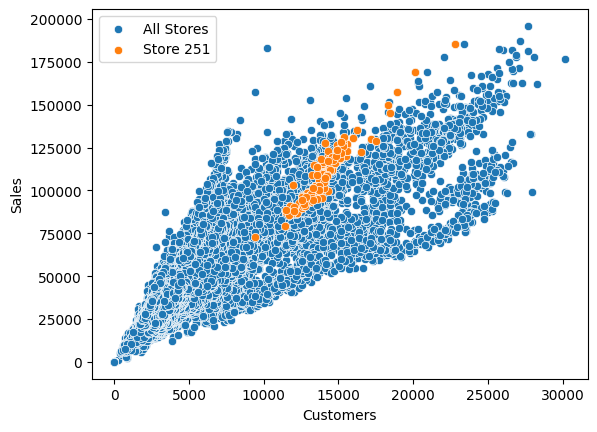

In [66]:
sns.scatterplot(data = df, x = 'Customers', y = 'Sales', label = 'All Stores')
sns.scatterplot(data = df[df['Store'] == 251], x = 'Customers', y = 'Sales', label = 'Store 251')

The orange dots are the store we are currently looking at. This store has really good general sales and amount of customers, not just some high points, as you can see in the plot.

Now we're going to address the performance statistics of the stores as a whole as well as the individual ones. We're going to look at sales, customers, average sales per day, sales per customer and customers per day.

In [67]:
# Overall store performance statstics

df[['Sales', 'Customers', 'AvgSalesPerDay', 'SalesPerCustomer', 'CustomersPerDay']].describe()

,Sales,Customers,AvgSalesPerDay,SalesPerCustomer,CustomersPerDay
count,150525.000000,150525.000000,150525.000000,150525.000000,150525.000000
mean,39017.974576,4278.636472,6747.189342,9.243559,736.303276
std,17797.508576,2434.028920,2992.075142,2.656353,388.736203
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28259.000000,2983.000000,4927.000000,7.854379,521.666667
50%,36799.000000,3835.000000,6372.500000,9.227262,666.333333
75%,47259.000000,5023.000000,8158.333333,10.873919,868.166667
max,195930.000000,30188.000000,30941.000000,26.057389,4312.571429


In [68]:
# Individual store performance statstics
# Enter whichever store id you want (here still 251)
# At the end of this project we will have an input reader to get store performance statistics

df[df['Store'] == 251][['Sales', 'Customers', 'AvgSalesPerDay', 'SalesPerCustomer', 'CustomersPerDay']].describe()

,Sales,Customers,AvgSalesPerDay,SalesPerCustomer,CustomersPerDay
count,135.000000,135.000000,135.000000,135.000000,135.000000
mean,110347.185185,14140.251852,19173.702346,7.781231,2456.390864
std,16818.620338,1672.209646,2779.933402,0.438699,260.952589
min,73117.000000,9421.000000,14511.666667,6.875486,2037.833333
25%,97035.000000,13200.000000,17074.616667,7.426477,2282.600000
50%,110599.000000,14042.000000,19056.333333,7.747337,2405.600000
75%,120411.500000,14961.500000,20684.083333,8.161497,2542.333333
max,185646.000000,22832.000000,30941.000000,9.045525,3805.333333


# Creating a Prediction Model

In this section we're going to create our model to ultimately make an accurate prediction for eight weeks after the dataset. We will also check the different models' accuracy and compare it to a method that uses the historical mean values.

First we're creating train- and test variables with our current DataFrame. Since we have a regression model taking the root square mean values and the R^2 score is a good way of evaluating our models.

In [69]:
# Import metrics to evaluate the models

from sklearn.metrics import mean_squared_error, r2_score

In [70]:
# Create a copy of our DataFrame for convenience purposes

df_c = df.copy()

We're going to handle some more data to ensure stability in our prediction models, or in some cases to even have the ability to use them. More concretely, we're going to remove 'Promo2SinceYear' and 'CompetitionSinceYear'. The latter will be removed for lack of sufficient amount of data.

In [71]:
# Remove 'Promo2SinceYear' and 'CompetitionOpenSinceYear

df_c.drop(['Promo2SinceYear', 'CompetitionOpenSinceYear'], axis = 1, inplace = True)

In [72]:
# Double check df_c for missing values

df_c.isna().any()

Store                  False
Date                   False
Sales                  False
Customers              False
Open                   False
Promo                  False
StateHoliday           False
SchoolHoliday          False
StoreType              False
Assortment             False
CompetitionDistance    False
Promo2                 False
PromoInterval          False
AvgSalesPerDay         False
CustomersPerDay        False
SalesPerCustomer       False
dtype: bool

Now it is important to remove the variables linked to the target variable to properly generalize the model, so we're going to get rid of all the columns we added earlier.

In [73]:
df_c.drop(['AvgSalesPerDay', 'CustomersPerDay', 'SalesPerCustomer'], axis = 1, inplace = True)

In [74]:
df_c.head()

,Store,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,PromoInterval
0,1,2013-01-06,19340,2500,4,0,"a, 0",6,c,a,1270.0,0,None
1,1,2013-01-13,32952,3918,6,5,0,5,c,a,1270.0,0,None
2,1,2013-01-20,25978,3417,6,0,0,0,c,a,1270.0,0,None
3,1,2013-01-27,33071,3862,6,5,0,0,c,a,1270.0,0,None
4,1,2013-02-03,28693,3561,6,0,0,0,c,a,1270.0,0,None


In [75]:
# Setting the date as index enables usage of the models coming up

df_c.set_index('Date', inplace = True)

In [76]:
# We're creating a standard ratio of train_size : test_size of 0.75 : 0.25
# Set random state to 0
# Target variable is 'Sales'
# Stratify after 'Store' ensures that every store will have elements in the training- and testdata


X_train, X_test, y_train, y_test = train_test_split(
    df_c.drop('Sales', axis = 1),
    df_c['Sales'],
    random_state = 0,
    stratify = df_c['Store'],
)


In [77]:
# Check if the data split correctly

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(len(np.unique(X_train['Store'])))

# It looks like we have the split we wanted

(112893, 11)
(37632, 11)
(112893,)
(37632,)
1115


Now we're importing and using different tools to preprocess our DataFrame. We're taking 'OrdinalEncoder' since there seems to be an order in the non-numeric variables, 'StandardScaler' since there aren't too great outliers in the dataset and finally we're going to make use of a pipeline to tie up everything nicely.

In [78]:
# Import encoder, scaler and pipeline

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

In [79]:
# make a list of categorical variables

categorical_variables = []

for column in df.columns:
    if df[column].dtype == object:
        categorical_variables.append(column)

categorical_variables

['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']

In [80]:
# Instance the encoder

encoder = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)

In [81]:
# Fit and transform the encoder
# Use encoder on the categorical variables

X_train_enc = encoder.fit_transform(X_train[categorical_variables])

In [82]:
X_test_enc = encoder.transform(X_test[categorical_variables])

In [83]:
# Replace the categorical columns on X_train with the encoded values

X_train[['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']] = X_train_enc

In [84]:
X_train.head()

,Store,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,PromoInterval
Date,,,,,,,,,,,
2014-12-21,790,5307,6,5,0.0,0,3.0,2.0,9070.0,0,3.0
2014-12-07,219,2776,6,5,0.0,0,0.0,0.0,1640.0,0,3.0
2015-03-08,549,3249,6,5,0.0,5,0.0,2.0,2330.0,0,3.0
2013-03-31,821,5293,5,5,2.0,5,0.0,0.0,1700.0,0,3.0
2014-10-05,1042,3311,5,5,1.0,0,0.0,0.0,3440.0,1,0.0


In [85]:
# Replace the categorical columns on X_test with the encoded values

X_test[['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']] = X_test_enc

In [86]:
# Import models to test

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge

We will compare our models to just taking the historical mean values. Within the pipelines it will be helpful if we create a regressor:

In [87]:
# Regressor from the mean values

class DummyRegressor:
    def fit(self, X, y):
        self.mean_ = y.mean()
    def predict(self, X):
        return np.full(X.shape[0], self.mean_)

In [88]:
# Define the models to test

models = {
    'RandomForest': RandomForestRegressor(random_state = 0),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'DummyRegressor': DummyRegressor()
}

# Note: I have individually tried other models like logistic regression, SGDClassifier and others but they either took too much memory or took too long to compute

In [89]:
# Create and evaluate pipelines for the models

for model_name, model in models.items():
    pipeline = make_pipeline(StandardScaler(), model)
    pipeline.fit(X_train, y_train)

    # Training set
    y_train_pred = pipeline.predict(X_train)
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

    # Test set
    y_test_pred = pipeline.predict(X_test)
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    print(f'{model_name} Training RMSE: {train_rmse:.2f}, Training R^2: {train_r2:.2f}')
    print(f'{model_name} Test RMSE: {test_rmse:.2f}, Test R^2: {test_r2:.2f}')

RandomForest Training RMSE: 968.76, Training R^2: 1.00
RandomForest Test RMSE: 2593.31, Test R^2: 0.98
LinearRegression Training RMSE: 7950.52, Training R^2: 0.80
LinearRegression Test RMSE: 7985.15, Test R^2: 0.80
Ridge Training RMSE: 7950.52, Training R^2: 0.80
Ridge Test RMSE: 7985.15, Test R^2: 0.80
DummyRegressor Training RMSE: 17770.64, Training R^2: 0.00
DummyRegressor Test RMSE: 17877.64, Test R^2: -0.00


It does look like the random forest regressor is the best model for us with the lowest root mean square aeror and the best R^2 score! We should fix the pipeline to the corresponding model.

In [90]:
pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(random_state = 0))
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=0))])

To create a prediction for the eight weeks after the samples end we need to create a DataFrame with the same conditions as our training data earlier.

In [91]:
from datetime import datetime, timedelta

In [92]:
last_date = df['Date'].max()
future_dates = [last_date + timedelta(weeks = i) for i in range(1, 9)]

In [93]:
future_df = pd.DataFrame({'Date': future_dates})

In [94]:
future_df

,Date
0,2015-08-09
1,2015-08-16
2,2015-08-23
3,2015-08-30
4,2015-09-06
5,2015-09-13
6,2015-09-20
7,2015-09-27


In [95]:
# Count the amount of stores

unique_stores = df['Store'].unique()

In [96]:
# Make a DataFrame out of it

stores_df = pd.DataFrame({'Store': unique_stores})

In [97]:
# Get the crossproduct of dates and stores

future_df = future_df.merge(stores_df, how='cross')

In [98]:
# 1115 stores times eight weeks

len(future_df)

8920

In [99]:
# Add store data variables

future_df = future_df.merge(store_data, on = 'Store', how = 'left')

In [100]:
train_features = X_train.columns

In [101]:
# Add the train data variables

for feature in train_features:
    if feature not in future_df.columns:
        future_df[feature] = 0  # fill value

At this point we can only speculate for some values. Since we cannot leave the values at zero for an authentic prediction we will go through the creation of the simulated data one by one.

The fill value of 0 seems fine for the school holiday variable.

Since the standard amount of opening days is six per week except for store type 'b' which has seven days per week.

In [102]:
future_df['Open'] = 6

In [103]:
future_df.loc[future_df['StoreType'] == 'b', 'Open'] = 7

In [104]:
future_df['Open'].value_counts()

Open
6    8784
7     136
Name: count, dtype: int64

For promotions we will just use the mean value.

In [105]:
future_df['Promo'] = df['Promo'].mean()

To simulate customers we are going to randomize the values within a certain range based on historical mean values for every single store.

In [106]:
# Fix RNG
# Get the mean number of customers for each store
# Determine the number of entries to generate for each store in future_df
# Generate random customer values, emulate some variance
# Assign the generated values to 'Customers' future_df

np.random.seed(17)

store_mean_customers = df.groupby('Store')['Customers'].mean()

for store_id in future_df['Store'].unique():

    mean_customers = store_mean_customers.loc[store_id]
    num_entries = future_df[future_df['Store'] == store_id].shape[0]
    random_customers = np.random.randint(
        int(mean_customers * (2/3)), 
        int(mean_customers * (4/3)), 
        size=num_entries
    )
    
    future_df.loc[future_df['Store'] == store_id, 'Customers'] = random_customers

In [107]:
future_df.head()

,Date,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,2015-08-09,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,None,3589,6,2.578176,0,0
1,2015-08-09,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",3804,6,2.578176,0,0
2,2015-08-09,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",3891,6,2.578176,0,0
3,2015-08-09,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,None,5283,6,2.578176,0,0
4,2015-08-09,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,None,2502,6,2.578176,0,0


We need to ensure that we have the same variables and conditions as when using the training data, so we still need to do some modifications. Those including removing variables, indexing by date and using the encoder.

In [108]:
future_df.drop(['Promo2SinceWeek', 'Promo2SinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'], axis = 1, inplace = True)

In [109]:
future_df.set_index('Date', inplace = True)

We can leave the state holiday value at zero since it's the most common value but we need to make sure it is a string for encoding.

In [110]:
future_df['StateHoliday'] = '0'

In [111]:
# Take the categorical variables we extracted from df earlier

future_df_enc = encoder.transform(future_df[categorical_variables])

In [112]:
future_df[categorical_variables] = future_df_enc

In [113]:
# Ensure the columns are in the right order

future_X = future_df[train_features]

In [114]:
# Predict the sales with the scaler and random forest

future_sales_pred = pipeline.predict(future_X)

In [115]:
future_df['PredictedSales'] = future_sales_pred

In [116]:
future_df['PredictedSales'].sort_values(ascending = False)

Date
2015-08-16    175207.310
2015-09-13    175207.310
2015-09-27    173963.730
2015-08-09    173963.730
2015-08-16    168489.890
                 ...    
2015-09-06     10999.590
2015-09-27     10884.070
2015-08-16     10873.080
2015-08-23     10852.584
2015-09-27     10811.470
Name: PredictedSales, Length: 8920, dtype: float64

In [117]:
# Add the same derivate data that df has to future_df

future_df['AvgSalesPerDay'] = future_df['PredictedSales'] / future_df['Open']
future_df['CustomersPerDay'] = future_df['Customers'] / future_df['Open']
future_df['SalesPerCustomer'] = future_df['PredictedSales'] / future_df['Customers']

In [118]:
# Reset the index from 'Date'

future_df = future_df.reset_index()

In [119]:
future_df.head()

,Date,Store,StoreType,Assortment,CompetitionDistance,Promo2,PromoInterval,Customers,Open,Promo,StateHoliday,SchoolHoliday,PredictedSales,AvgSalesPerDay,CustomersPerDay,SalesPerCustomer
0,2015-08-09,1,2.0,0.0,1270.0,0,3.0,3589,6,2.578176,0.0,0,31141.290000,5190.215000,598.166667,8.676871
1,2015-08-09,2,0.0,0.0,570.0,1,1.0,3804,6,2.578176,0.0,0,33978.303333,5663.050556,634.000000,8.932256
2,2015-08-09,3,0.0,0.0,14130.0,1,1.0,3891,6,2.578176,0.0,0,42607.640000,7101.273333,648.500000,10.950306
3,2015-08-09,4,2.0,2.0,620.0,0,3.0,5283,6,2.578176,0.0,0,49944.630000,8324.105000,880.500000,9.453839
4,2015-08-09,5,0.0,0.0,29910.0,0,3.0,2502,6,2.578176,0.0,0,25598.486667,4266.414444,417.000000,10.231210


With this we have created an eight week prediction for sales for the Rossmann stores.

# Looking up the results

Finally we can look up our final results here.

Let us look at the average performance of all the stores in both historical and predicted data:

In [120]:
hist_avg_sales = df['Sales'].mean()
pred_avg_sales = future_df['PredictedSales'].mean()

In [121]:
print(f'Average sales over the course of the dataset: {hist_avg_sales}')

Average sales over the course of the dataset: 39017.97457565188


In [122]:
print(f'Average predicted sales: {pred_avg_sales}')

Average predicted sales: 41542.97741227978


In [123]:
# Creating a plot with historical and predicted average sales
# Overall store average versus individual store average
# Create a function that plots this

def create_sales_plot(df, future_df, store_id):
    historical_data = df.copy()
    predicted_data = future_df.copy()

    # Average sales for all stores
    historical_avg_sales = historical_data.groupby('Date')['Sales'].mean().reset_index()
    predicted_avg_sales = predicted_data.groupby('Date')['PredictedSales'].mean().reset_index()

    # Average sales for a specific store
    historical_store_sales = historical_data[historical_data['Store'] == store_id][['Date', 'Sales']]
    predicted_store_sales = predicted_data[predicted_data['Store'] == store_id][['Date', 'PredictedSales']]

    # Creating the plot
    plt.figure(figsize=(14, 7))

    # Plot historical data
    sns.lineplot(x = 'Date', y = 'Sales', data=historical_avg_sales, label = 'Historical Average Sales (All Stores)', linestyle='--', color = 'blue')
    sns.lineplot(x = 'Date', y = 'Sales', data=historical_store_sales, label = f'Historical Sales (Store {store_id})', color = 'blue')

    # Plot predicted data
    sns.lineplot(x = 'Date', y = 'PredictedSales', data=predicted_avg_sales, label = 'Predicted Average Sales (All Stores)', linestyle='--', color = 'orange')
    sns.lineplot(x = 'Date', y = 'PredictedSales', data=predicted_store_sales, label = f'Predicted Sales (Store {store_id})', color = 'orange')
    
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title('Historical and Predicted Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

The following magical cell will give you the descriptive statstics as well as a beautiful line plot to check up on a store's sales and predicted sales and compare it to the overall average sales and their predicted sales.

Store ID number: 251
Historical sales data:
               Sales     Customers  AvgSalesPerDay  CustomersPerDay
count     135.000000    135.000000      135.000000       135.000000
mean   110347.185185  14140.251852    19173.702346      2456.390864
std     16818.620338   1672.209646     2779.933402       260.952589
min     73117.000000   9421.000000    14511.666667      2037.833333
25%     97035.000000  13200.000000    17074.616667      2282.600000
50%    110599.000000  14042.000000    19056.333333      2405.600000
75%    120411.500000  14961.500000    20684.083333      2542.333333
max    185646.000000  22832.000000    30941.000000      3805.333333
Predicted sales data:
       PredictedSales     Customers  AvgSalesPerDay  CustomersPerDay
count        8.000000      8.000000        8.000000         8.000000
mean    117474.672500  14607.625000    19579.112083      2434.604167
std      16409.407146   2426.455259     2734.901191       404.409210
min     101019.530000  11496.000000    16836.5

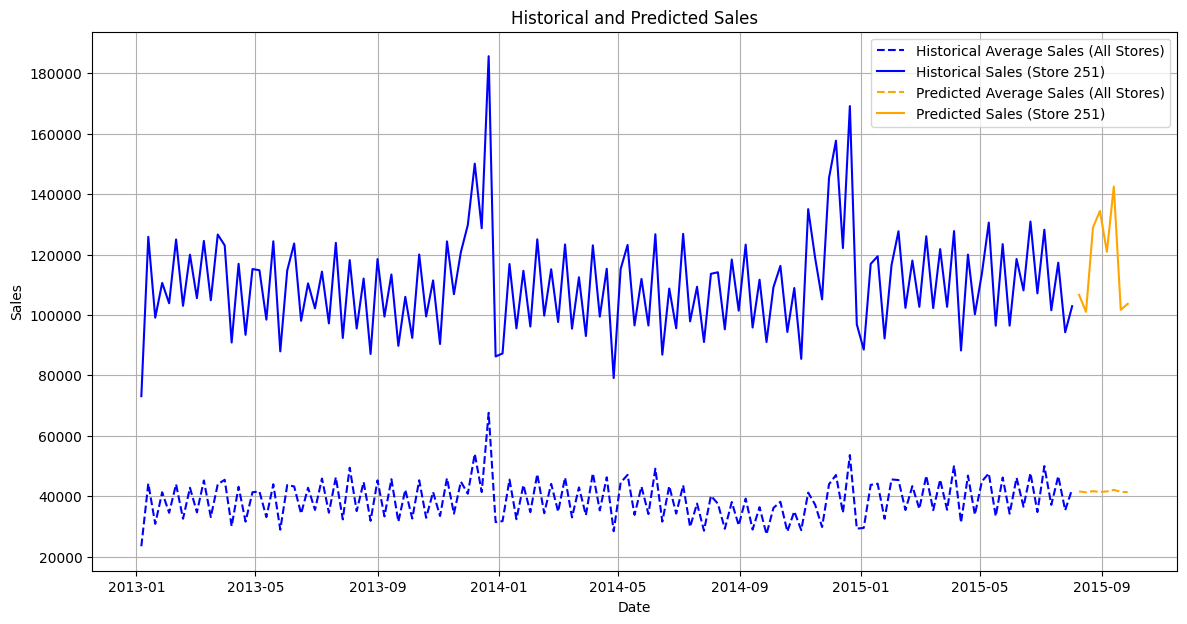

In [124]:
store_id_input = input('Please enter a store id')

if int(store_id_input) not in range(1, len(np.unique(df['Store'])) + 1):
    print('Please insert a valid store ID.')

else:

    print('Store ID number: ' + store_id_input)

    print('Historical sales data:')
    print(df[df['Store'] == int(store_id_input)][['Sales', 'Customers', 'AvgSalesPerDay', 'CustomersPerDay']].describe())

    print('Predicted sales data:')
    print(future_df[future_df['Store'] == int(store_id_input)][['PredictedSales', 'Customers', 'AvgSalesPerDay', 'CustomersPerDay']].describe())
    create_sales_plot(df, future_df, int(store_id_input))

# I did not include sales per customer in this one to keep a more compact format - these variables are very interchangeable if necessary

# Concluding thoughts

For the Rossmann stores to improve their sales they can consider one or more of the following points:

* Several stores had record sales before Christmas and around the Easter holidays so keeping them open around that time can lead to record sales - that mostly applies for already successful stores since there are also record low sales during weeks with holidays.
* You can look at the success of store type 'b' and try to emulate it - but be careful! Since there were only a handful of stores with this type the information is not very reliable. Additionally this store type has a high customer count with lower sales per customer combined with opening on Sundays. This leads to way more strain on the store clerics.
* Regular promotions tend to be successful in a fair amount cases. Ongoing promotions tend to be more polarising - the reason for that likely just lies in trying to help stores with lower sales count and at that point just not seeing results yet.
* Look at the historical performance statstics for each individual store and consider other external factors.